# Data Cleaning 

### From Kaggle Kernels:
#### Extensive Sberbank Exploratory Analysis:
**source:** https://www.kaggle.com/captcalculator/a-very-extensive-sberbank-exploratory-analysis/comments#latest-185178

* 37 observations where life_sq is greater than full_sq.
* A vast majority of the apartments have three rooms or less.
* Look to see how life sq ~ price changes based on sub-area or distance to kremlin
* Home price does seem to increase with population density.
* There does not appear to be a relationship between the mean home price in a district and the district’s share of working age population.
* Surprisingly, there is little to no correlation between price and the school variables. The school variables however are highly correlated with each other, indicating that we would not want to use all of them in a linear regression model due to multicollinearity.
* homes with >3 top 20 universities show signs of correlation, but only one house fits that description.
* raions that have a top 25 cultural object have a median home sale price that is higher by 1.2 million (using this feature as a factor)
* strong positive correlation between sport_objects_raion and price_doc

#### Simple Exploration Notebook - Sberbank
**source:** https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-sberbank/comments/notebook

* overall increasing trend in price as floor_num increases. A sudden increase in the house price is also observed at floor 18.
* Individual houses seems to be costlier, check price of 0 floor houses.

#### Map visualizations with external shapefile
**source:** https://www.kaggle.com/jtremoureux/map-visualizations-with-external-shapefile/notebook

* replace regions with map shapefile coordinates



## Import Libraries & Data

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from datetime import datetime

# load dataset
train_df = pd.read_csv("../Sberbank/train.csv", parse_dates=['timestamp'], index_col=False, low_memory=False)
test_df = pd.read_csv("../Sberbank/test.csv", parse_dates=['timestamp'], index_col=False, low_memory=False)
macro_df = pd.read_csv("../Sberbank/macro.csv", parse_dates=['timestamp'], index_col=False, low_memory=False)

### Merge Train & Test

In [2]:
frames = [train_df, test_df]

df = pd.concat(frames)

### Add Macro

In [3]:
# add macro data to train/test data

train_df = pd.merge(train_df, macro_df, how='left', on='timestamp')
test_df = pd.merge(test_df, macro_df, how='left', on='timestamp')

df = pd.merge(df, macro_df, how='left', on='timestamp')

## Transformations

### Add Date/Time 

In [4]:
# add month, day, year to train and test data
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['year'] = df['timestamp'].dt.year

# Add month-year
month_year = (df.timestamp.dt.month + df.timestamp.dt.year * 100)
month_year_map = month_year.value_counts().to_dict()
df['month_year'] = month_year.map(month_year_map)


# Add week-year count
week_year = (df.timestamp.dt.weekofyear + df.timestamp.dt.year * 100)
week_year_map = week_year.value_counts().to_dict()
df['week_year'] = week_year.map(week_year_map)


# Add month and day-of-week
df['month'] = df.timestamp.dt.month
df['dow'] = df.timestamp.dt.dayofweek

### Price:

In [5]:
df['price_doc_log'] = np.log1p(df['price_doc'])
df['price_doc_log10'] = np.log10(df['price_doc'])

### Unit Size:

In [6]:
# squared and square root of full sq
df['full_sq^2'] = np.square(df['full_sq'])
df['full_sqrt'] = np.sqrt(df['full_sq'])

# floor ratios
df['rel_floor'] = df['floor'] / df['max_floor'].astype(float)
df['rel_kitch_sq'] = df['kitch_sq'] / df['full_sq'].astype(float)


# area and population density
df['area_km'] = df['area_m'] / 1000000
df['density'] = df['raion_popul'] / df['area_km']


# working population
df['work_share'] = df['work_all'] / df['raion_popul']

## Adding Lags and calculating deltas

#### Create lag timestamps for one month, three months, 6 months, and 12 months.

In [7]:
df['one_month_lag'] = df['timestamp'] - pd.to_timedelta('30 days')
df['three_month_lag'] = df['timestamp'] - pd.to_timedelta('90 days')
df['six_month_lag'] = df['timestamp'] - pd.to_timedelta('180 days')
df['twelve_month_lag'] = df['timestamp'] - pd.to_timedelta('360 days')

In [8]:
# df[['timestamp', 'one_month_lag', 'three_month_lag', 'six_month_lag', 'twelve_month_lag']]

### Join macro features with chosen delay intervals

In [9]:
lag_features = ['timestamp' ,'oil_urals', 'gdp_quart',
                'cpi', 'usdrub', 'micex_cbi_tr', 'labor_force']
# 1-month lag
df = pd.merge(df, macro_df[lag_features], how = 'left', left_on='one_month_lag', right_on='timestamp', suffixes=('','_1'))
# 3-month lag
df = pd.merge(df, macro_df[lag_features], how = 'left', left_on='three_month_lag', right_on='timestamp', suffixes=('','_3'))
# 6 month lag
df = pd.merge(df, macro_df[lag_features], how = 'left', left_on='six_month_lag', right_on='timestamp', suffixes=('','_6'))
# 12 month lag
df = pd.merge(df, macro_df[lag_features], how = 'left', left_on='twelve_month_lag', right_on='timestamp', suffixes=('','_12'))

### Deltas:

### Oil:

In [10]:
df['delta_oil_1'] = (df['oil_urals'] - df['oil_urals_1']) / df['oil_urals']
df['delta_oil_3'] = (df['oil_urals'] - df['oil_urals_3']) / df['oil_urals']
df['delta_oil_6'] = (df['oil_urals'] - df['oil_urals_6']) / df['oil_urals']
df['delta_oil_12'] = (df['oil_urals'] - df['oil_urals_12']) / df['oil_urals']

### Currency

In [11]:
df['delta_usdrub_1'] = (df['usdrub'] - df['usdrub_1']) / df['usdrub']
df['delta_usdrub_3'] = (df['usdrub'] - df['usdrub_3']) / df['usdrub']
df['delta_usdrub_6'] = (df['usdrub'] - df['usdrub_6']) / df['usdrub']
df['delta_usdrub_12'] = (df['usdrub'] - df['usdrub_12']) / df['usdrub']

### Labor Force

In [12]:
df['delta_labor_force_1'] = (df['labor_force'] - df['labor_force_1']) / df['labor_force']
df['delta_labor_force_3'] = (df['labor_force'] - df['labor_force_3']) / df['labor_force']
df['delta_labor_force_6'] = (df['labor_force'] - df['labor_force_6']) / df['labor_force']
df['delta_labor_force_12'] = (df['labor_force'] - df['labor_force_12']) / df['labor_force']

# micex_rgbi_tr

In [13]:
df['micex_rgbi_tr_1'] = (df['labor_force'] - df['labor_force_1']) / df['labor_force']
df['micex_rgbi_tr_3'] = (df['labor_force'] - df['labor_force_3']) / df['labor_force']
df['micex_rgbi_tr_6'] = (df['labor_force'] - df['labor_force_6']) / df['labor_force']
df['micex_rgbi_tr_12'] = (df['labor_force'] - df['labor_force_12']) / df['labor_force']

## Manual Imputing:

In [14]:
# Cleaning values with incorrect information 
df.loc[df['state'] == 33, 'state'] = 3
df = df.loc[df['id'] != 24718] 
df = df.loc[df['floor'] != 0] 

df.loc[df['build_year'] == 20052009, 'build_year'] = 2009
df.loc[df['build_year'] == 215, 'build_year'] = 2015
df = df.loc[df['build_year'] != 4965, :]
df.loc[df['build_year'] == 0, 'build_year'] = df['year']
df.loc[df['build_year'] == 1, 'build_year'] = df['year']
df.loc[df['build_year'] == 2, 'build_year'] = df['year']
df.loc[df['build_year'] == 3, 'build_year'] = df['year']
df.loc[df['build_year'] == 20, 'build_year'] = 1920
df.loc[df['build_year'] == 71, 'build_year'] = 1971
df.loc[df['build_year'] == 1691, 'build_year'] = 1961


14158    1860.0
27751    1860.0
35079    1875.0
17212    1876.0
29517    1886.0
37938    1890.0
23174    1890.0
19541    1890.0
23117    1890.0
34357    1890.0
18933    1890.0
18079    1890.0
32012    1895.0
16581    1895.0
15282    1896.0
12068    1896.0
37822    1898.0
17296    1900.0
22778    1900.0
34071    1902.0
21897    1904.0
31442    1905.0
28821    1905.0
22665    1906.0
35353    1906.0
17582    1907.0
8056     1907.0
35352    1908.0
15306    1910.0
19514    1910.0
          ...  
37939       NaN
37951       NaN
37952       NaN
37957       NaN
37972       NaN
37988       NaN
37992       NaN
38000       NaN
38001       NaN
38004       NaN
38006       NaN
38037       NaN
38038       NaN
38045       NaN
38055       NaN
38059       NaN
38060       NaN
38061       NaN
38077       NaN
38081       NaN
38085       NaN
38089       NaN
38095       NaN
38106       NaN
38109       NaN
38113       NaN
38120       NaN
38126       NaN
38127       NaN
38129       NaN
Name: build_year, Length

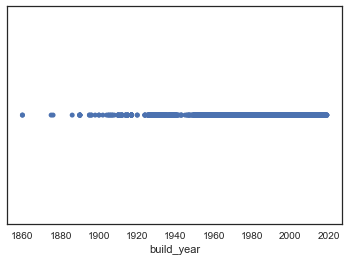

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style="white", color_codes=True)

%matplotlib inline

# grid = sns.JointGrid(x, y, space=0, size=12, ratio=50)

sns.stripplot(df['build_year'])
df['build_year'].sort_values()

## Functions for Scaling/Normalizing/Reshaping
 (Note: not necessary for Random Forest Models)

In [16]:
# def rescale(feature):
#     return feature.apply(lambda x: (x - np.mean(x))/np.std(x))

# def normalize(feature):
#     return feature.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))

#### Check dtypes and split objects and numeric types

In [17]:
df_numerics = df.select_dtypes(exclude=['object'])
df_objects = df.select_dtypes(include=['object'])

#### Normalize and rescale numeric features

In [18]:
# df_numerics.loc[:, df_numerics.columns != 'timestamp'] = df_numerics.select_dtypes(exclude=['datetime'])

### Merge again

In [19]:
frames = [df_numerics, df_objects]

df = pd.concat(frames,axis=1)

In [20]:
df.shape

(38122, 454)

### Creating X and y sets

In [21]:
y_full = df['price_doc'].values
X_full = df.loc[:, df.columns != 'price_doc'].values

### Add imputed build and state values

In [22]:
# build = pd.read_csv('./df_build_year_2017-05-26.csv')
# state = pd.read_csv('./df_state_2017-05-26.csv')

In [23]:
# df.loc[df['build_year'].isnull(), 'build_year'] = build['build_year']
# df.loc[df['state'].isnull(), 'state'] = state['state']

Check to see if any feature consists of non-float value

#### Confirm data's status before saving

In [24]:
df['build_year'].describe()
df['state'].describe()

count    23872.000000
mean         2.070585
std          0.841263
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: state, dtype: float64

## Save to CSV

In [25]:
df.to_csv('./cleaned_df_{0}.csv'.format(datetime.date(datetime.now())), index=False)